In [12]:
def getFPI(fpi, fpName):
    if fpi == "":
        return np.nan
    
    fpiList = fpi.strip().split('\n')
    fpiDict = {}
    for fp in fpiList:
        fp = fp.strip().split(':')
        fpiDict[fp[0].strip()] = fp[1].strip()

    return fpiDict[fpName]

def getSubHyperPipeline(buffer):
    """
    buffer = { 
                fnA : [ [passA1, passA2, ...., passAN],
                        [fpiA1,  fpiA2,  ...., fpiAN ] ],
                fnB : [ [passB1, passB2, ...., passBM],
                        [fpiB1,  fpiB2,  ...., fpiBM ] ]
             }

    subHyperPipeline = [
                            [pass1, pass2, ...., passN],
                            [   {fnA: fpiA1, fnB: fpiB1},
                                {fnA: fpiA2, fnB: fpiB2},
                                ....
                                {fnA: fpiAN, fnB: fpiBN},
                            ]
                       ]
    """
    print("*"*10," buffer ", "*"*10)
    print(buffer)

    subHyperPipeline = [[],[]]
    if all(value[0] == list(buffer.values())[0][0] for value in buffer.values()):
        subHyperPipeline[0] = list(buffer.values())[0][0]
        for i in range(len(subHyperPipeline[0])):
            tempDict = {}
            for key in buffer:
                tempDict[key] = buffer[key][1][i]
            subHyperPipeline[1].append(tempDict)
    else:
        """for key in buffer:
            print(key)
            print(buffer[key])
            print("##########")
        print("*"*40)"""

        _, maxKey= max((len(v), k) for k,v in buffer.items())
        subHyperPipeline[0] = buffer.pop(maxKey)[0]

        for key in buffer:
            pointer = 0
            missingPasses = {}
            for i in range(len(buffer[key][0])):
                startPoint = pointer
                while buffer[key][0][i] != subHyperPipeline[0][pointer] and pointer < len(subHyperPipeline[0]):
                    pointer += 1
                if pointer == len(subHyperPipeline[0]):
                    pointer = startPoint
                    missingPasses[buffer[key][0][i]] = startPoint
                    print("#"*50)
                    print("PASSES MISSING. FIX IT")
                    print(missingPasses)
                    sys.exit("ERROR!!!! PASSES MISSING. FIX IT")

        pointers = dict.fromkeys(list(buffer.keys()), 0)
        for i in range(len(subHyperPipeline[0])):
            tempDict = {}
            for key in buffer:
                if subHyperPipeline[0][i] == buffer[key][0][pointers[key]]:
                    tempDict[key] = buffer[key][1][pointers[key]]
                    pointers[key] += 1
                else:
                    tempDict[key] = np.nan
            subHyperPipeline[1].append(tempDict)
    
    print("*"*10," subHyperPipeline ", "*"*10)
    print(subHyperPipeline)
    print()

    if len(subHyperPipeline[0]) == len(subHyperPipeline[1]):
        return subHyperPipeline
    else: 
        sys.exit("ERROR!!!! FPI MISSING. FIX IT")

def getHyperPassPipeline(rawDataList, fpName):
    hyperPassPipeline = [[],[]]
    buffer = {}
    functions = []
    postOrderFunctions = []
    prevFunction = ''

    for i in range(len(rawDataList)):
        passName = rawDataList[i][1]
        functionName = rawDataList[i][2]
        functionProperties = getFPI(rawDataList[i][3], fpName)

        """
        Ignore llvm.lifetim~ functions.
        """
        if functionName.startswith('llvm.lifetime.'):
            continue

        """
        Maintain a buffer for each function, and reset it whenever the pass pipeline starts running on  the first function again.
        """
        if functionName in functions:
            if prevFunction != functionName:
                subHyperPipeline = getSubHyperPipeline(buffer)
                hyperPassPipeline[0] += subHyperPipeline[0]
                hyperPassPipeline[1] += subHyperPipeline[1]
                buffer.clear()
                functions.clear()
            elif len(functions) > 1 and buffer[functions[-1]] == buffer[functions[-2]]:
                subHyperPipeline = getSubHyperPipeline(buffer)
                hyperPassPipeline[0] += subHyperPipeline[0]
                hyperPassPipeline[1] += subHyperPipeline[1]
                postOrderFunctions = functions
                buffer.clear()
                functions.clear()
            elif postOrderFunctions and passName.startswith('ModuleToPostOrderCGSCCPassAdaptor'):
                subHyperPipeline = getSubHyperPipeline(buffer)
                hyperPassPipeline[0] += subHyperPipeline[0]
                hyperPassPipeline[1] += subHyperPipeline[1]
                postOrderFunctions.clear()
                buffer.clear()
                functions.clear()

        if functionName not in functions:
            functions.append(functionName)

        if functionName not in buffer:
            buffer[functionName] = [[],[]]
        buffer[functionName][0].append(passName)
        buffer[functionName][1].append(functionProperties)

        if i == len(rawDataList) - 1:
            subHyperPipeline = getSubHyperPipeline(buffer)
            hyperPassPipeline[0] += subHyperPipeline[0]
            hyperPassPipeline[1] += subHyperPipeline[1]

        prevFunction = functionName
        
    return hyperPassPipeline

In [13]:
import sys
import numpy as np  

fileName = 'test.c.txt'
    
with open(fileName) as inFile:
    rawData = inFile.read()

rawDataList = list(map(str.strip, rawData.strip().split('***')))[1:]

for i in range(len(rawDataList)):
    rawDataList[i] = list(map(str.strip, rawDataList[i].strip().split('#')))

In [14]:
hyperPassPipeline = getHyperPassPipeline(rawDataList, 'BasicBlockCount')

**********  buffer  **********
{'main': [['ForceFunctionAttrsPass'], [nan]], 'multiply': [['ForceFunctionAttrsPass'], [nan]]}
**********  subHyperPipeline  **********
[['ForceFunctionAttrsPass'], [{'main': nan, 'multiply': nan}]]

**********  buffer  **********
{'main': [['EntryExitInstrumenterPass'], ['1']], 'multiply': [['EntryExitInstrumenterPass'], ['13']]}
**********  subHyperPipeline  **********
[['EntryExitInstrumenterPass'], [{'main': '1', 'multiply': '13'}]]

**********  buffer  **********
{'main': [['ModuleToFunctionPassAdaptor<llvm::EntryExitInstrumenterPass>'], [nan]], 'multiply': [['ModuleToFunctionPassAdaptor<llvm::EntryExitInstrumenterPass>'], [nan]]}
**********  subHyperPipeline  **********
[['ModuleToFunctionPassAdaptor<llvm::EntryExitInstrumenterPass>'], [{'main': nan, 'multiply': nan}]]

**********  buffer  **********
{'main': [['InferFunctionAttrsPass'], [nan]], 'multiply': [['InferFunctionAttrsPass'], [nan]]}
**********  subHyperPipeline  **********
[['InferFunctio

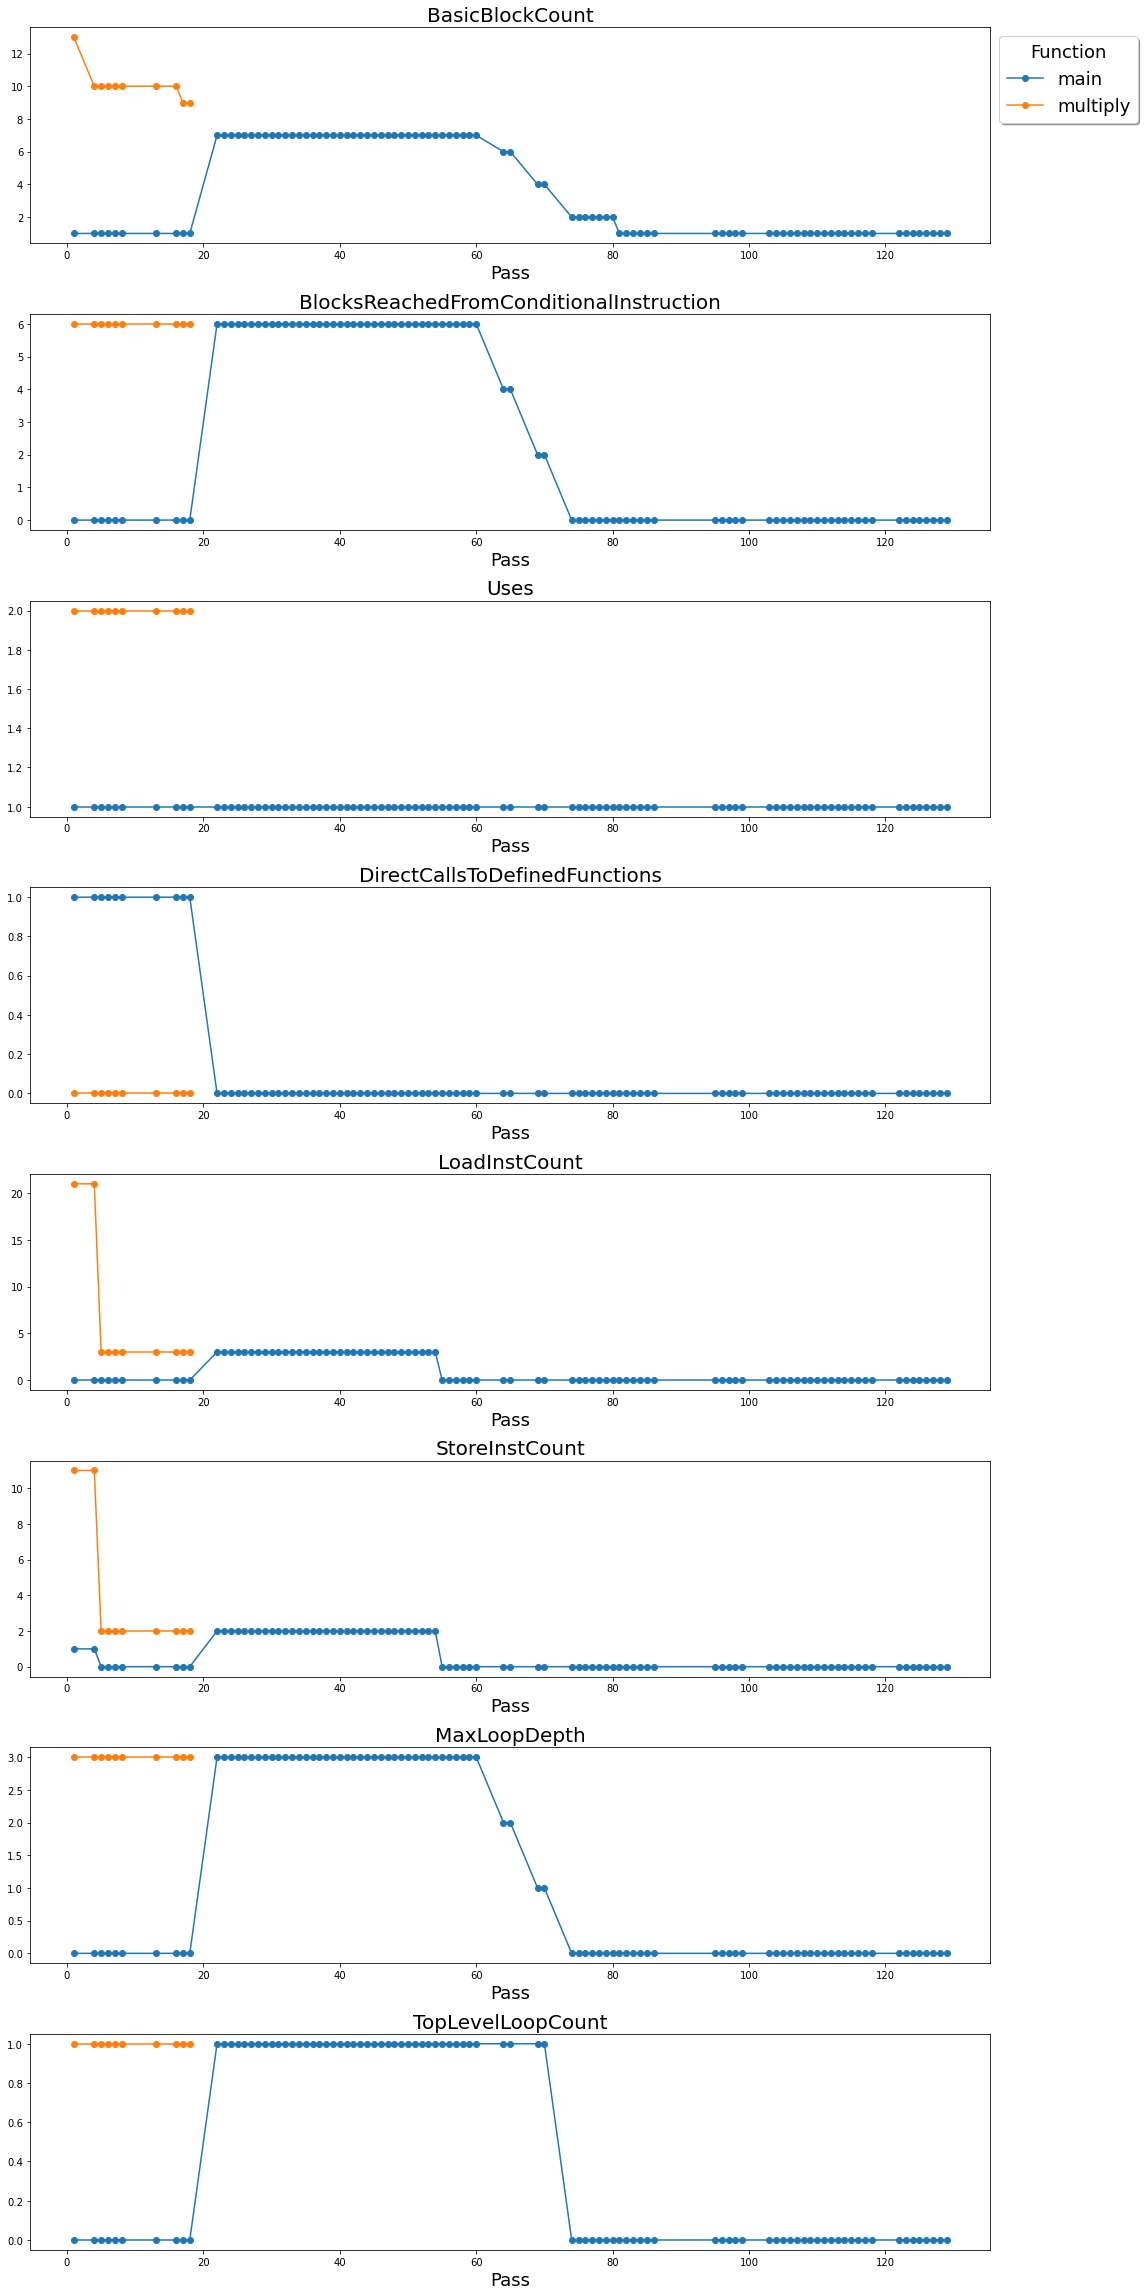

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def splitSeriesToArray(series):
    return [series.index, series.to_numpy()]

functionPropertiesNames = ['BasicBlockCount', 'BlocksReachedFromConditionalInstruction',
                           'Uses', 'DirectCallsToDefinedFunctions', 'LoadInstCount', 
                           'StoreInstCount', 'MaxLoopDepth', 'TopLevelLoopCount']
numFunctionProperties = len(functionPropertiesNames)

fig, axs = plt.subplots(numFunctionProperties, 1, figsize = (16,4*numFunctionProperties))

for i in range(numFunctionProperties):
    hyperPassPipeline = getHyperPassPipeline(rawDataList, functionPropertiesNames[i])
    
    passes_df = pd.DataFrame(hyperPassPipeline[0])
    passes_df.columns = ['pass']
    functions_df = pd.DataFrame(hyperPassPipeline[1])
    functions_df = functions_df.apply(pd.to_numeric)
    
    joined_df = passes_df.join(functions_df)
    
    functionsList = list(functions_df.columns)
    for function in functionsList:
        axs[i].plot( *splitSeriesToArray(joined_df[function].dropna()), label=function, marker='o')
    axs[i].set_title(functionPropertiesNames[i], fontsize=20)
    axs[i].set_xlabel("Pass", fontsize=18)

plt.rcParams['legend.title_fontsize'] = 18
axs[0].legend(loc='upper left', title="Function", fontsize=18, bbox_to_anchor=(1, 1), fancybox=True, shadow=True)
fig.tight_layout()

In [5]:
fig.savefig("foo.png", bbox_inches='tight')

In [6]:
passes = ""
passesList = list(passes_df['pass'])
for i in range(len(passesList)):
    passes += passesList[i] + "\n"
print(passes)

ForceFunctionAttrsPass
EntryExitInstrumenterPass
ModuleToFunctionPassAdaptor<llvm::EntryExitInstrumenterPass>
InferFunctionAttrsPass
SimplifyCFGPass
SROA
EarlyCSEPass
LowerExpectIntrinsicPass
PassManager<llvm::Function>
ModuleToFunctionPassAdaptor<llvm::PassManager<llvm::Function> >
IPSCCPPass
CalledValuePropagationPass
GlobalOptPass
PromotePass
ModuleToFunctionPassAdaptor<llvm::PromotePass>
DeadArgumentEliminationPass
InstCombinePass
SimplifyCFGPass
PassManager<llvm::Function>
ModuleToFunctionPassAdaptor<llvm::PassManager<llvm::Function> >
RequireAnalysisPass<llvm::GlobalsAA, llvm::Module, llvm::AnalysisManager<llvm::Module>>
RequireAnalysisPass<llvm::ProfileSummaryAnalysis, llvm::Module, llvm::AnalysisManager<llvm::Module>>
InlinerPass
PostOrderFunctionAttrsPass
SROA
EarlyCSEPass
SimplifyCFGPass
InstCombinePass
LibCallsShrinkWrapPass
SimplifyCFGPass
ReassociatePass
RequireAnalysisPass<llvm::OptimizationRemarkEmitterAnalysis, llvm::Function, llvm::AnalysisManager<llvm::Function>>
Loop

# Testing for the Entire Benchmark

In [57]:
import sys
import numpy as np

fileName = 't-suite_MultiSource_Applications_SPASS_clause.c.txt'

with open(fileName) as inFile:
    rawData = inFile.read()

rawDataList = list(map(str.strip, rawData.strip().split('***')))[1:]

for i in range(len(rawDataList)):
    rawDataList[i] = list(map(str.strip, rawDataList[i].strip().split('#')))

In [58]:
def getFPI(fpi, fpName):
    if fpi == "":
        return np.nan
    
    fpiList = fpi.strip().split('\n')
    fpiDict = {}
    for fp in fpiList:
        fp = fp.strip().split(':')
        fpiDict[fp[0].strip()] = fp[1].strip()

    return fpiDict[fpName]

def getSubHyperPipeline(buffer):
    """
    buffer = { 
                fnA : [ [passA1, passA2, ...., passAN],
                        [fpiA1,  fpiA2,  ...., fpiAN ] ],
                fnB : [ [passB1, passB2, ...., passBM],
                        [fpiB1,  fpiB2,  ...., fpiBM ] ]
             }

    subHyperPipeline = [
                            [pass1, pass2, ...., passN],
                            [   {fnA: fpiA1, fnB: fpiB1},
                                {fnA: fpiA2, fnB: fpiB2},
                                ....
                                {fnA: fpiAN, fnB: fpiBN},
                            ]
                       ]
    """

    subHyperPipeline = [[],[]]
    if all(value[0] == list(buffer.values())[0][0] for value in buffer.values()):
        subHyperPipeline[0] = list(buffer.values())[0][0]
        for i in range(len(subHyperPipeline[0])):
            tempDict = {}
            for key in buffer:
                tempDict[key] = buffer[key][1][i]
            subHyperPipeline[1].append(tempDict)
    else:
        """for key in buffer:
            print(key)
            print(buffer[key])
            print("##########")
        print("*"*40)"""

        _, maxKey= max((len(v), k) for k,v in buffer.items())
        subHyperPipeline[0] = buffer.pop(maxKey)[0]

        for key in buffer:
            pointer = 0
            missingPasses = {}
            for i in range(len(buffer[key][0])):
                startPoint = pointer
                while pointer < len(subHyperPipeline[0]) and buffer[key][0][i] != subHyperPipeline[0][pointer]:
                    pointer += 1
                if pointer == len(subHyperPipeline[0]):
                    pointer = startPoint
                    missingPasses[buffer[key][0][i]] = startPoint
                    #print("#"*50)
                    #print("PASSES MISSING. FIX IT")
            #print(missingPasses)

        pointers = dict.fromkeys(list(buffer.keys()), 0)
        for i in range(len(subHyperPipeline[0])):
            tempDict = {}
            for key in buffer:
                if subHyperPipeline[0][i] == buffer[key][0][pointers[key]]:
                    tempDict[key] = buffer[key][1][pointers[key]]
                    pointers[key] += 1
                else:
                    tempDict[key] = np.nan
            subHyperPipeline[1].append(tempDict)

    if len(subHyperPipeline[0]) == len(subHyperPipeline[1]):
        return subHyperPipeline
    else: 
        sys.exit("ERROR!!!! FPI MISSING. FIX IT")

def getHyperPassPipeline(rawDataList, fpName):
    hyperPassPipeline = [[],[]]
    buffer = {}
    functions = []
    postOrderFunctions = []
    prevFunction = ''

    for i in range(len(rawDataList)):
        passName = rawDataList[i][1]
        functionName = rawDataList[i][2]
        functionProperties = getFPI(rawDataList[i][3], fpName)

        """
        Ignore llvm.lifetim~ functions.
        """
        if functionName.startswith('llvm.lifetime.'):
            continue

        """
        Maintain a buffer for each function, and reset it whenever the pass pipeline starts running on  the first function again.
        """
        if functionName in functions:
            if prevFunction != functionName:
                subHyperPipeline = getSubHyperPipeline(buffer)
                hyperPassPipeline[0] += subHyperPipeline[0]
                hyperPassPipeline[1] += subHyperPipeline[1]
                buffer.clear()
                functions.clear()
            elif len(functions) > 1 and buffer[functions[-1]] == buffer[functions[-2]]:
                subHyperPipeline = getSubHyperPipeline(buffer)
                hyperPassPipeline[0] += subHyperPipeline[0]
                hyperPassPipeline[1] += subHyperPipeline[1]
                postOrderFunctions = functions
                buffer.clear()
                functions.clear()
            elif postOrderFunctions and passName.startswith('ModuleToPostOrderCGSCCPassAdaptor'):
                subHyperPipeline = getSubHyperPipeline(buffer)
                hyperPassPipeline[0] += subHyperPipeline[0]
                hyperPassPipeline[1] += subHyperPipeline[1]
                postOrderFunctions.clear()
                buffer.clear()
                functions.clear()

        if functionName not in functions:
            functions.append(functionName)

        if functionName not in buffer:
            buffer[functionName] = [[],[]]
        buffer[functionName][0].append(passName)
        buffer[functionName][1].append(functionProperties)

        if i == len(rawDataList) - 1:
            subHyperPipeline = getSubHyperPipeline(buffer)
            hyperPassPipeline[0] += subHyperPipeline[0]
            hyperPassPipeline[1] += subHyperPipeline[1]

        prevFunction = functionName
        
    return hyperPassPipeline


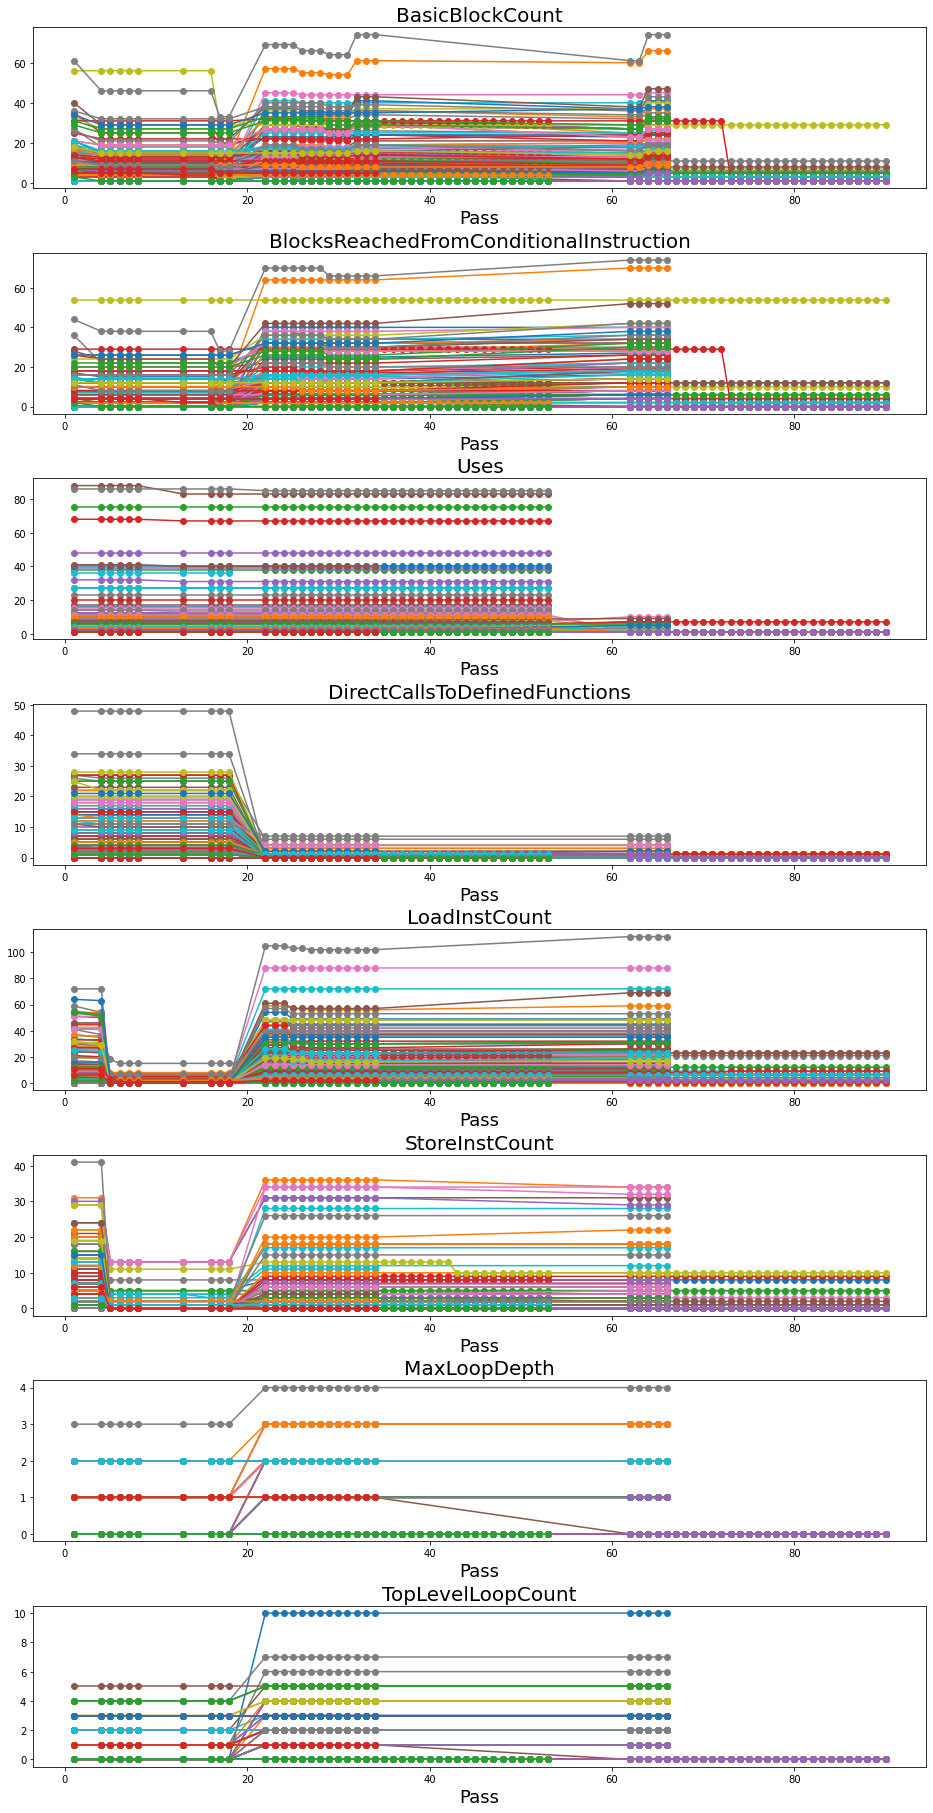

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

def splitSeriesToArray(series):
    return [series.index, series.to_numpy()]

functionPropertiesNames = ['BasicBlockCount', 'BlocksReachedFromConditionalInstruction',
                           'Uses', 'DirectCallsToDefinedFunctions', 'LoadInstCount', 
                           'StoreInstCount', 'MaxLoopDepth', 'TopLevelLoopCount']
numFunctionProperties = len(functionPropertiesNames)

fig, axs = plt.subplots(numFunctionProperties, 1, figsize = (16,4*numFunctionProperties))

for i in range(numFunctionProperties):
    hyperPassPipeline = getHyperPassPipeline(rawDataList, functionPropertiesNames[i])
    
    passes_df = pd.DataFrame(hyperPassPipeline[0])
    passes_df.columns = ['pass']
    functions_df = pd.DataFrame(hyperPassPipeline[1])
    functions_df = functions_df.apply(pd.to_numeric)
    
    joined_df = passes_df.join(functions_df)
    
    functionsList = list(functions_df.columns)
    for function in functionsList:
        axs[i].plot( *splitSeriesToArray(joined_df[function].dropna()), label=function, marker='o')
    axs[i].set_title(functionPropertiesNames[i], fontsize=20)
    axs[i].set_xlabel("Pass", fontsize=18)

plt.subplots_adjust(hspace = 0.4)
plt.rcParams['legend.title_fontsize'] = 18
#axs[0].legend(loc='upper left', title="Function", fontsize=18, ncol=4, bbox_to_anchor=(1, 1), fancybox=True, shadow=True)

In [68]:
fig.savefig("foo4.png", bbox_inches='tight')

In [69]:
passes = ""
passesList = list(passes_df['pass'])
for i in range(len(passesList)):
    passes += passesList[i] + "\n"
print(passes)

ForceFunctionAttrsPass
EntryExitInstrumenterPass
ModuleToFunctionPassAdaptor<llvm::EntryExitInstrumenterPass>
InferFunctionAttrsPass
SimplifyCFGPass
SROA
EarlyCSEPass
LowerExpectIntrinsicPass
PassManager<llvm::Function>
ModuleToFunctionPassAdaptor<llvm::PassManager<llvm::Function> >
IPSCCPPass
CalledValuePropagationPass
GlobalOptPass
PromotePass
ModuleToFunctionPassAdaptor<llvm::PromotePass>
DeadArgumentEliminationPass
InstCombinePass
SimplifyCFGPass
PassManager<llvm::Function>
ModuleToFunctionPassAdaptor<llvm::PassManager<llvm::Function> >
RequireAnalysisPass<llvm::GlobalsAA, llvm::Module, llvm::AnalysisManager<llvm::Module>>
RequireAnalysisPass<llvm::ProfileSummaryAnalysis, llvm::Module, llvm::AnalysisManager<llvm::Module>>
InlinerPass
PostOrderFunctionAttrsPass
SROA
EarlyCSEPass
SimplifyCFGPass
InstCombinePass
LibCallsShrinkWrapPass
SimplifyCFGPass
ReassociatePass
RequireAnalysisPass<llvm::OptimizationRemarkEmitterAnalysis, llvm::Function, llvm::AnalysisManager<llvm::Function>>
Loop

In [24]:
import sys
import numpy as np

fileName = 'test.c.txt'
    
def getFPI(fpi, fpName):
    if fpi == "":
        return np.nan
    
    fpiList = fpi.strip().split('\n')
    fpiDict = {}
    for fp in fpiList:
        fp = fp.strip().split(':')
        fpiDict[fp[0].strip()] = fp[1].strip()

    return fpiDict[fpName]

def getSubHyperPipeline(buffer):
    """
    buffer = { 
                fnA : [ [passA1, passA2, ...., passAN],
                        [fpiA1,  fpiA2,  ...., fpiAN ] ],
                fnB : [ [passB1, passB2, ...., passBM],
                        [fpiB1,  fpiB2,  ...., fpiBM ] ]
             }

    subHyperPipeline = [
                            [pass1, pass2, ...., passN],
                            [   {fnA: fpiA1, fnB: fpiB1},
                                {fnA: fpiA2, fnB: fpiB2},
                                ....
                                {fnA: fpiAN, fnB: fpiBN},
                            ]
                       ]
    """

    subHyperPipeline = [[],[]]
    if all(value[0] == list(buffer.values())[0][0] for value in buffer.values()):
        subHyperPipeline[0] = list(buffer.values())[0][0]
        for i in range(len(subHyperPipeline[0])):
            tempDict = {}
            for key in buffer:
                tempDict[key] = buffer[key][1][i]
            subHyperPipeline[1].append(tempDict)
    else:
        """for key in buffer:
            print(key)
            print(buffer[key])
            print("##########")
        print("*"*40)"""

        _, maxKey= max((len(v), k) for k,v in buffer.items())
        subHyperPipeline[0] = buffer.pop(maxKey)[0]

        for key in buffer:
            pointer = 0
            missingPasses = {}
            for i in range(len(buffer[key][0])):
                startPoint = pointer
                while buffer[key][0][i] != subHyperPipeline[0][pointer] and pointer < len(subHyperPipeline[0]):
                    pointer += 1
                if pointer == len(subHyperPipeline[0]):
                    pointer = startPoint
                    missingPasses[buffer[key][0][i]] = startPoint
                    print("#"*50)
                    print("PASSES MISSING. FIX IT")
                    print(missingPasses)
                    sys.exit("ERROR!!!! PASSES MISSING. FIX IT")

        pointers = dict.fromkeys(list(buffer.keys()), 0)
        for i in range(len(subHyperPipeline[0])):
            tempDict = {}
            for key in buffer:
                if subHyperPipeline[0][i] == buffer[key][0][pointers[key]]:
                    tempDict[key] = buffer[key][1][pointers[key]]
                    pointers[key] += 1
                else:
                    tempDict[key] = np.nan
            subHyperPipeline[1].append(tempDict)

    if len(subHyperPipeline[0]) == len(subHyperPipeline[1]):
        return subHyperPipeline
    else: 
        sys.exit("ERROR!!!! FPI MISSING. FIX IT")

def getHyperPassPipeline(rawDataList, fpName):
    hyperPassPipeline = [[],[]]
    buffer = {}
    functions = []
    postOrderFunctions = []
    prevFunction = ''

    for i in range(len(rawDataList)):
        passName = rawDataList[i][1]
        functionName = rawDataList[i][2]
        functionProperties = getFPI(rawDataList[i][3], fpName)

        """
        Ignore llvm.lifetim~ functions.
        """
        if functionName.startswith('llvm.lifetime.'):
            continue

        """
        Maintain a buffer for each function, and reset it whenever the pass pipeline starts running on  the first function again.
        """
        if functionName in functions:
            if prevFunction != functionName:
                subHyperPipeline = getSubHyperPipeline(buffer)
                hyperPassPipeline[0] += subHyperPipeline[0]
                hyperPassPipeline[1] += subHyperPipeline[1]
                buffer.clear()
                functions.clear()
            elif len(functions) > 1 and buffer[functions[-1]] == buffer[functions[-2]]:
                subHyperPipeline = getSubHyperPipeline(buffer)
                hyperPassPipeline[0] += subHyperPipeline[0]
                hyperPassPipeline[1] += subHyperPipeline[1]
                postOrderFunctions = functions
                buffer.clear()
                functions.clear()
            elif postOrderFunctions and passName.startswith('ModuleToPostOrderCGSCCPassAdaptor'):
                subHyperPipeline = getSubHyperPipeline(buffer)
                hyperPassPipeline[0] += subHyperPipeline[0]
                hyperPassPipeline[1] += subHyperPipeline[1]
                postOrderFunctions.clear()
                buffer.clear()
                functions.clear()

        if functionName not in functions:
            functions.append(functionName)

        if functionName not in buffer:
            buffer[functionName] = [[],[]]
        buffer[functionName][0].append(passName)
        buffer[functionName][1].append(functionProperties)

        if i == len(rawDataList) - 1:
            subHyperPipeline = getSubHyperPipeline(buffer)
            hyperPassPipeline[0] += subHyperPipeline[0]
            hyperPassPipeline[1] += subHyperPipeline[1]

        prevFunction = functionName
        
    return hyperPassPipeline
        
with open(fileName) as inFile:
    rawData = inFile.read()

rawDataList = list(map(str.strip, rawData.strip().split('***')))[1:]

for i in range(len(rawDataList)):
    rawDataList[i] = list(map(str.strip, rawDataList[i].strip().split('#')))

In [26]:
fruits1 = ["orange", "pear", "apple", "pear", "orange"]
fruits2 = ["pear","apple","banana", "orange"]
aln = global_align(fruits1, fruits2)
identity = aln[0]
score = aln[1]
print(identity, score)
print(aln[2])
print(aln[3])


0.5 45
['orange', 'pear', 'apple', '-', 'pear', 'orange']
['-', 'pear', 'apple', 'banana', '-', 'orange']


In [ ]:
def zeros(shape):
    retval = []
    for x in range(shape[0]):
        retval.append([])
        for y in range(shape[1]):
            retval[-1].append(0)
    return retval

match_award      = 20
mismatch_penalty = -1000000
gap_penalty      = -5 # both for opening and extanding

def match_score(alpha, beta):
    if alpha == beta:
        return match_award
    elif alpha == '-' or beta == '-':
        return gap_penalty
    else:
        return mismatch_penalty

def global_align(pair1, pair2):
    seq1, meta1 = pair1 
    seq2, meta2 = pair2
    "seq2 is the longer one with multiple keys in the dictionary"
    seq1.reverse()    #reverse sequence 1
    seq2.reverse()    #reverse sequence 2 
    meta1.reverse()
    meta2.reverse()
 
    m, n = len(seq1), len(seq2)  # length of two sequences
    
    # Generate DP table and traceback path pointer matrix
    score = zeros((m+1, n+1))      # the DP table
   
    # Calculate DP table
    for i in range(0, m + 1):
        score[i][0] = gap_penalty * i
    for j in range(0, n + 1):
        score[0][j] = gap_penalty * j
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score[i - 1][j - 1] + match_score(seq1[i-1], seq2[j-1])
            delete = score[i - 1][j] + gap_penalty
            insert = score[i][j - 1] + gap_penalty
            score[i][j] = max(match, delete, insert)

    # Traceback and compute the alignment 
    join = []
    joined_meta = []
    
    i,j = m,n # start from the bottom right cell
    while i > 0 and j > 0: # end toching the top or the left edge
        score_current = score[i][j]
        score_diagonal = score[i-1][j-1]
        score_up = score[i][j-1]
        score_left = score[i-1][j]

        if score_current == score_diagonal + match_score(seq1[i-1], seq2[j-1]):
            align1.append(seq1[i-1])
            align2.append(seq2[j-1])
            join.append(seq1[i-1])
            
            aligned_meta1.append(meta1[i-1]) # meta1 has only one key
            aligned_meta2.append(meta2[j-1])
            temp_dict = meta2[j-1]
            meta1_key = list(meta1[i-1].keys())[0]
            temp_dict[meta1_key] = meta1[i-1][meta1_key]
            joined_meta.append(temp_dict)
            
            i -= 1
            j -= 1
        elif score_current == score_left + gap_penalty:
            align1.append(seq1[i-1])
            align2.append('-')
            join.append(seq1[i-1])
            
            aligned_meta1.append(meta1[i-1])
            aligned_meta2.append('-')
            temp_dict = dict.fromkeys(list(meta2[0].keys()), np.nan) 
            #keys are the same for all the dictionaries in meta2, so get keys from the 0th one
            meta1_key = list(meta1[i-1].keys())[0]
            temp_dict[meta1_key] = meta1[i-1][meta1_key]
            joined_meta.append(temp_dict)
            
            i -= 1
        elif score_current == score_up + gap_penalty:
            align1.append('-')
            align2.append(seq2[j-1])
            join.append(seq2[j-1])
            
            aligned_meta1.append('-')
            aligned_meta2.append(meta2[j-1])
            temp_dict = meta2[j-1]
            meta1_key = list(meta1[i-1].keys())[0]
            temp_dict[meta1_key] = np.nan
            joined_meta.append(temp_dict)
        
            j -= 1


    # Finish tracing up to the top left cell
    while i > 0:
        align1.append(seq1[i-1])
        align2.append('-')
        join.append(seq1[i-1])
        
        aligned_meta1.append(meta1[i-1])
        aligned_meta2.append('-')
        temp_dict = dict.fromkeys(list(meta2[0].keys()), np.nan) 
        #keys are the same for all the dictionaries in meta2, so get keys from the 0th one
        meta1_key = list(meta1[i-1].keys())[0]
        temp_dict[meta1_key] = meta1[i-1][meta1_key]
        joined_meta.append(temp_dict)
        
        i -= 1
    while j > 0:
        align1.append('-')
        align2.append(seq2[j-1])
        join.append(seq2[j-1])
        
        aligned_meta1.append('-')
        aligned_meta2.append(meta2[j-1])
        temp_dict = meta2[j-1]
        meta1_key = list(meta1[i-1].keys())[0]
        temp_dict[meta1_key] = np.nan
        joined_meta.append(temp_dict)
        
        j -= 1    
    
    print(align1)
    print(align2)
    print(join)
    print(joined_meta)
    print()

    return [align1, aligned_meta1], [align2, aligned_meta2]